In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rand
img = cv2.imread('rov_pool.jpg')
cap = cv2.VideoCapture('AUV_Vid.mkv')
ret, frame = cap.read()

In [37]:
def detect_lines(
    img,
    threshold1: int = 50,
    threshold2: int = 100,
    apertureSize: int = 3,
    minLineLength: int = 100,
    maxLineGap: int = 10,
):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    edges = cv2.Canny(
        gray, threshold1, threshold2, apertureSize=apertureSize
    )  # detect edges
    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180,
        100,
        minLineLength=minLineLength,
        maxLineGap=maxLineGap,
    )  # detects lines

    return lines

In [38]:

def draw_lines(img, lines, color):
    color_order = [(0,255,0),(0,0,255),(255,0,0),(100,100,100),(0,0,0),(150,30,90),(180,50,20)]
    slope_list = []
    line_list = []
    i=0
    j=0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        slope_list.append(slope)
        line_list.append(([x1,y1,x2,y2]))
        i+=1
        i=i%6
        j+=1

        for k in range(len(slope_list)):
            if np.abs(slope)>.9:
                if round(slope,2) == round(slope_list[k],2):
                    cv2.line(img, (x1, y1), (line_list[k][2], line_list[k][3]), color_order[i], 10)
                else:
                    cv2.line(img, (x1, y1), (x2, y2), color_order[i], 2)

In [39]:
def get_slopes_intercepts(lines):
    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            slope = None
            intercept = x1
        else:
            slope = (y2 - y1) / (x2 - x1)
            if y2 == y1:
                intercept = None
            else:
                intercept = (slope*x1-y1)/slope
                
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

In [40]:
def detect_lanes(lines):
    slopes, intercepts = get_slopes_intercepts(lines)
    lanes = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            slope_diff_threshold = 1
            intercept_diff_threshold = 40
            slope_diff = abs(slopes[i] - slopes[j])
            intercept_diff = abs(intercepts[i] - intercepts[j])
            if slope_diff < slope_diff_threshold and intercept_diff < intercept_diff_threshold:
                lanes.append([lines[i], lines[j]])
    return lanes

In [41]:
def draw_lanes(img, lanes):
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (255, 255, 0)]
    for idx, lane in enumerate(lanes):
        color = colors[idx % len(colors)]
        for line in lane:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness=5)

In [42]:
def get_lane_center(lanes):
    slope = (get_slopes_intercepts(lanes[0])[0][0] + get_slopes_intercepts(lanes[0])[0][1]) / 2
    if lanes is None:
        pass
    else:

        center = ((get_slopes_intercepts(lanes[0]))[0][0] + (get_slopes_intercepts(lanes[0]))[0][1]) / 2
        for i in range(0, len(lanes)-1):
            lane_center = (get_slopes_intercepts(lanes[i])[0][0] + get_slopes_intercepts(lanes[i+1])[0][1]) / 2
            # we get intercepts for line 1 and line 2 for each lane and get the average
            if np.abs(lane_center - len(img[1])/2) < np.abs(center - len(img[0])/2):
                center = lane_center


                print((center, slope))


        return center, slope

In [43]:
def recommend_direction(center, slope):
    image_width = 1920
    center_threshold = 0.1  # A threshold to determine if the center is in the middle
    center_position = center / image_width
    if center_position < 0.5 - center_threshold:
        return "left"
    elif center_position > 0.5 + center_threshold:
        return "right"
    else:
        return "forward"

In [44]:
a = detect_lines(img, 50, 150, 3, 100, 10)
print(a)

[[[388 215 567 525]]

 [[663 239 945 341]]

 [[742 289 944 371]]

 [[434 295 569 530]]

 [[661 255 785 306]]

 [[420 406 457 530]]

 [[364 220 458 529]]]


In [45]:
print(draw_lines(img, a, (0,255,0)))


None


In [46]:
b, c = get_slopes_intercepts(a)

In [47]:
d = detect_lanes(a)
print(d)

[[array([[388, 215, 567, 525]], dtype=int32), array([[434, 295, 569, 530]], dtype=int32)], [array([[663, 239, 945, 341]], dtype=int32), array([[742, 289, 944, 371]], dtype=int32)], [array([[663, 239, 945, 341]], dtype=int32), array([[661, 255, 785, 306]], dtype=int32)], [array([[742, 289, 944, 371]], dtype=int32), array([[661, 255, 785, 306]], dtype=int32)], [array([[420, 406, 457, 530]], dtype=int32), array([[364, 220, 458, 529]], dtype=int32)]]


In [48]:
print(draw_lanes(img, d))

None


In [49]:
f, g = get_lane_center(d)

(1.8465873183062986, 1.7362921580798676)


In [50]:
h = recommend_direction(f, g)

In [51]:
def Line_drawer(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    edges = cv2.Canny(gray, 30, 70) # detect edges using edge intensity of the gray version of the image.jpg,
    #  it detects the edges by establishing a color gradient along edges and using those gradients to define thin lines where edges should be,
    #  whether or not they are edges is then defined by whether the intensity of the shift in gradient is above or below certain thresholds
    #  that you define when calling Canny, so the second value you input is defined as the minimum threshold for gradient intensity,
    #  which if any edges have an intensity lower than that they are discarded, the second threshold is the maximum intensity, 
    #  which establishes that for any edges with a greater gradient intensity they are instantly accepted as edges, 
    #  and if some edges are in-between the thresholds, they are defined as edges or not based on whether they touch pixels that are a part of the edges.
    #  for the parameters I would suggest anywhere from 55-80 to 50-110


    slope_list=[]
    line_list=[]

    color_order=[(0,255,0),(0,0,255),(255,0,0),(100,100,100),(0,0,0),(150,30,90),(180,50,20)] #Color cycle list
    color_order=[(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0)] # In case you want all green, yes this is a backwards solution
    i=0
    j=0

    lines = cv2.HoughLinesP(edges,10,np.pi/210,10,minLineLength=100,maxLineGap=20,) # detect lines
    # takes in edges, an array of lines mapped in cartesian space onto the image resolution
    # also takes in Rho which is distance resolution
    # then it takes in Theta which is angular pixel resolution, note: only seems to work for pi/(k*30) values, where k is some natural number, idk why
    # then it takes in a threshold for lines it will show, only lines that get more than the thresholds votes will be shown. suggest to be 10
    # then it takes in minLineLength which states the minimum length required in pixels for a line to be shown
    # then it takes in maxLineGap which states the maximum distance between two lines in points in a line for those points to be considered apart of a single line


    if lines is not None:
        for line in lines:
            if line is not None and len(line) != 0:
                x1, y1, x2, y2 = line[0]
                if (x2-x1)!=0:
                    pass
                elif (x2-x1)==0:
                    x2+=.1
                    
                slope=(y2-y1)/(x2-x1)
                slope_list.append(slope)
                line_list.append(([x1,y1,x2,y2]))
                i+=1
                i=i%6
                j+=1

                # for k in range(len(slope_list)):
                #     if np.abs(slope)>.9:
                #         if round(slope,2) ==round(slope_list[k],2):
                #             (cv2.line(img,(x1,y1),(line_list[k][2],line_list[k][3]),color_order[i],10))
                #         else:
                (cv2.line(img, (x1, y1), (x2, y2), color_order[i], 10))
                ##return(img) used to be here but after moving it out I now get like 200 lines, before the problem was that my plotter would only show one line so maybe this will fix it
            else:
                pass
        else:
            pass
        return(img)

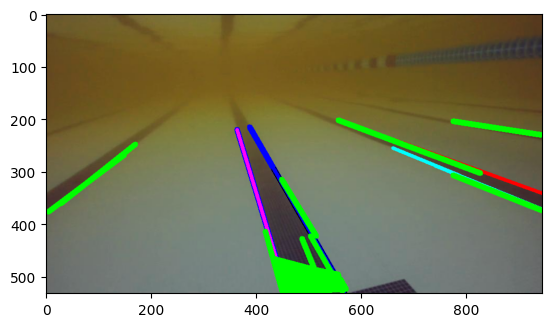

In [52]:
plt.imshow(Line_drawer(img))

In [53]:
img = cv2.imread('rov_pool.jpg')

In [54]:
cap = cv2.VideoCapture('AUV_Vid.mkv')
ret, frame = cap.read()

In [55]:
count=0
frequency=200
pic_list=[]
while ret:
    if count%frequency==0:
        a=detect_lines(frame)
        
        plt.imshow(draw_lines(detect_lines(frame)))
        plt.show()
        count+=1
    count+=1

    ret, frame = cap.read()

TypeError: draw_lines() missing 2 required positional arguments: 'lines' and 'color'